# NODDI Bingham

The recently proposed NODDI-Bingham model <cite data-cite="1647435/495J4QJC"></cite> extends NODDI to using a Bingham distribution instead of a Watson and describes the signal as

\begin{align}
 E^{\textrm{NODDI}}_{\textrm{Bingham}}= \underbrace{f_{\textrm{CSF}}\overbrace{E_{\textrm{iso}}(\cdot|D_{\textrm{CSF}})}^{\textrm{Ball}}}_{\textrm{CSF}}
                             +\overbrace{B(\kappa_1,\kappa_2,\boldsymbol{\mu}_i)}^{\textrm{Bingham}}\,*_{\mathbb{S}^2}\, \left[\underbrace{f_h\overbrace{E_{\textrm{h}}(\cdot|\lambda_\perp^{\textrm{tort}},\lambda_\parallel^{\textrm{tort}})}^{\textrm{Zeppelin}}}_{\textrm{Hindered Extra-Axonal}}+\underbrace{f_r\overbrace{E_r(\cdot|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}\right].
\end{align}

The added value of the Bingham distribution in NODDI has been shown in an \emph{ex-vivo} study on bending cortical fibers <cite data-cite="1647435/45ETDJLH"></cite>.
However, it does not address any of the other limitations of NODDI. It is also interesting to see that this model is equivalent to the BAR model if we set $N=1$ and add a tortuous Zeppelin.

## Generate NODDI-Bingham model

In [1]:
from mipy.signal_models import cylinder_models, gaussian_models
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G4Zeppelin()

In [3]:
from mipy.distributions.distribute_models import SD2BinghamDistributed
bingham_dispersed_bundle = SD2BinghamDistributed(models=[stick, zeppelin])
bingham_dispersed_bundle.parameter_names

['SD2Bingham_1_odi',
 'SD2Bingham_1_beta_fraction',
 'SD2Bingham_1_psi',
 'SD2Bingham_1_mu',
 'G4Zeppelin_1_lambda_perp',
 'C1Stick_1_lambda_par',
 'G4Zeppelin_1_lambda_par',
 'partial_volume_0']

In [4]:
bingham_dispersed_bundle.set_tortuous_parameter('G4Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
bingham_dispersed_bundle.set_equal_parameter('G4Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
bingham_dispersed_bundle.set_fixed_parameter('G4Zeppelin_1_lambda_par', 1.7e-9)

In [5]:
from mipy.core.modeling_framework import MultiCompartmentModel
NODDI_bingham_mod = MultiCompartmentModel(models=[ball, bingham_dispersed_bundle])

In [6]:
NODDI_bingham_mod.parameter_names

['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction',
 'SD2BinghamDistributed_1_SD2Bingham_1_odi',
 'SD2BinghamDistributed_1_SD2Bingham_1_mu',
 'SD2BinghamDistributed_1_partial_volume_0',
 'SD2BinghamDistributed_1_SD2Bingham_1_psi',
 'G3Ball_1_lambda_iso',
 'partial_volume_0',
 'partial_volume_1']

In [7]:
NODDI_bingham_mod.set_fixed_parameter('G3Ball_1_lambda_iso', 3e-9)

# Human Connectome Project Example

In [9]:
from mipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


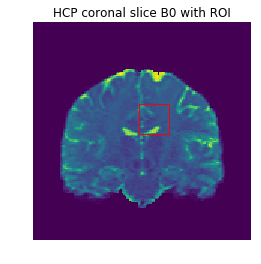

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

## Fit NODDI to HCP data

In [12]:
NODDI_fit_hcp = NODDI_bingham_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 61.3360249996 seconds
Fitting of 8181 voxels complete in 2200.6279161 seconds.
Average of 0.268992533443 seconds per voxel.


## Visualize results

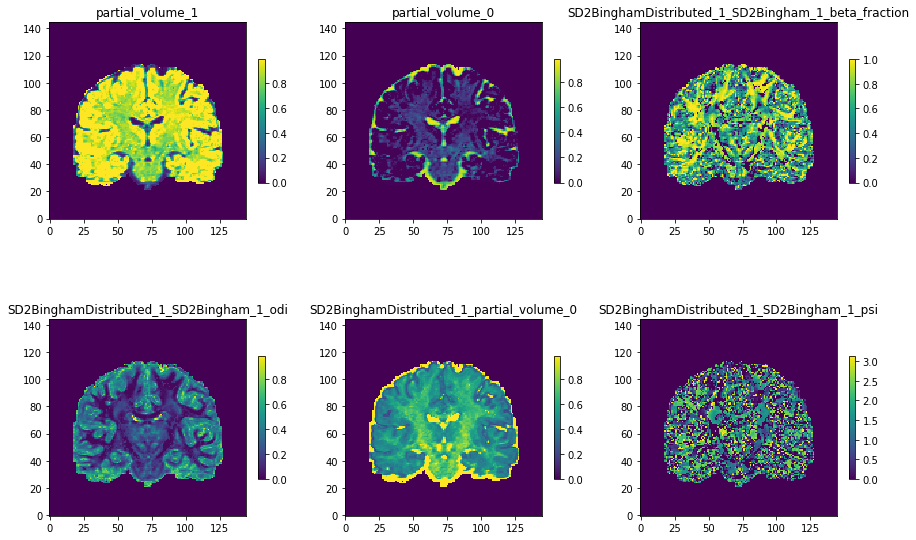

In [18]:
fitted_parameters = NODDI_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated ODI and beta_fraction as background.

In [14]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = NODDI_fit_hcp.fod(sphere.vertices)

In [51]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

odi_res = fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_odi']
odi_im = slicer(odi_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

beta_res = fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction']
beta_im = slicer(beta_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

In [56]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_odi.png')

ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, beta_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_beta.png')

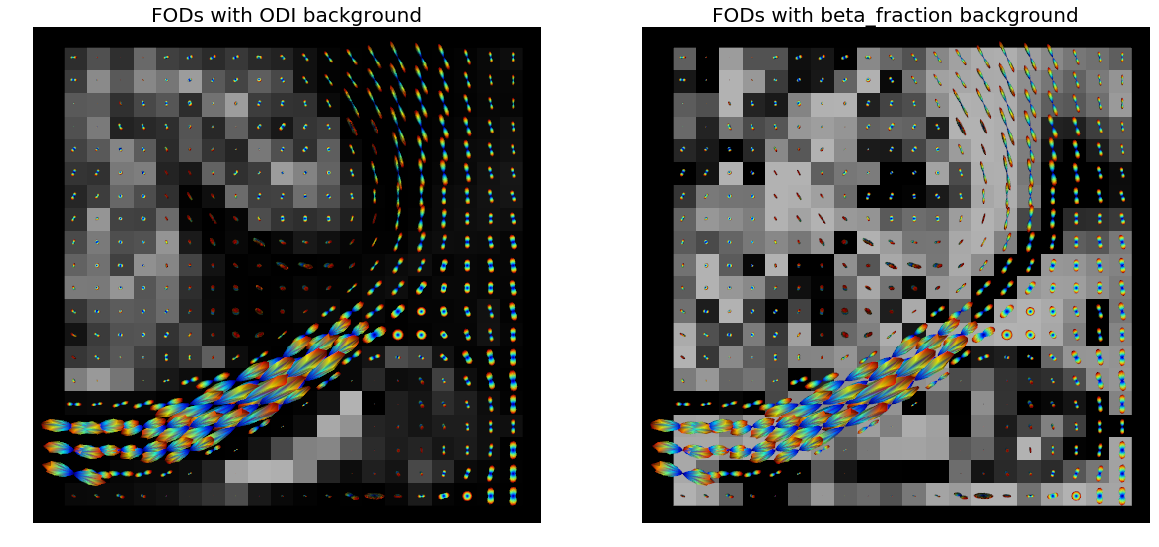

In [81]:
import matplotlib.image as mpimg
img1 = mpimg.imread('dipy_odi.png')
img2 = mpimg.imread('dipy_beta.png')

fig, axs = plt.subplots(1, 2, figsize=[20, 70])
axs[0].set_title('FODs with ODI background', fontsize=20)
axs[0].imshow(img1[100:-97, 100:-85])
axs[0].axis('off')
axs[1].set_title('FODs with beta_fraction background', fontsize=20)
axs[1].imshow(img2[100:-97, 100:-85])
axs[1].axis('off');

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. On the left, the intensity of the background shows the ODI of the Bingam distribution, inversely related to only $\kappa_1$. Notice it is low in the corpus callosum and higher in non-white matter areas. Also notice that NODDI-Bingham still cannot estimate crossings, which are expected in the centrum semiovale on the right. This biases any comparison/estimation of volume fractions and concentrations in these areas.

On the right, we show the FODs with beta_fraction as the background, which we related to $\kappa_1$ and $\kappa_2$ as $\kappa_2$=beta_fraction$*\kappa_1$. Since we limit beta_fraction between 0 and 1, this means that $\kappa_2$ is always limited between 0 and $\kappa_1$. Bright intensities indicate voxels where $\kappa_2$ is close to $\kappa_1$, meaning the axon dispersion is significantly anisotropic.

In [82]:
from os import remove
remove('dipy_odi.png')
remove('dipy_beta.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:924: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:905: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


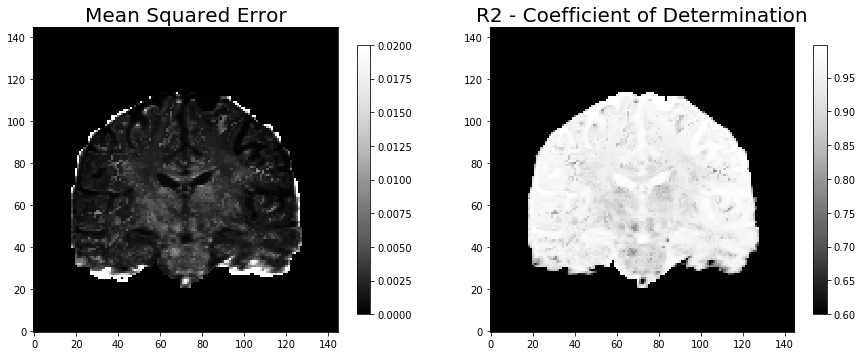

In [22]:
mse = NODDI_fit_hcp.mean_squared_error(data_hcp)
R2 = NODDI_fit_hcp.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. We can still see the structure of different brain structure in NODDI-Bingham, but they are becoming less obvious to see than in Ball and Stick or NODDI-Watson.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.

## Comparison MIX versus brute2fine optimization for FOD example

Given that NODDI-Bingham is starting to have many parameters, it is interesting to see if the Microstructure in Crossings (MIX) optimization algorithms will find the same result as our relatively straightforwardly implemented Brute2Fine algorithm. Since MIX takes considerably longer to fit, we will only study the are where we illustrated the FODs.

In [19]:
data_hcp_small = data_hcp[70:90,: , 70:90]
NODDI_fit_hcp_small = NODDI_bingham_mod.fit(scheme_hcp, data_hcp_small, solver='mix')

Using parallel processing with 8 workers.
Setup MIX optimizer in 5.96046447754e-06 seconds
Fitting of 400 voxels complete in 1390.47426891 seconds.
Average of 3.47618567228 seconds per voxel.


In [86]:
fods_mix = NODDI_fit_hcp_small.fod(sphere.vertices)
odi_res = NODDI_fit_hcp_small.fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_odi']
odi_im = slicer(odi_res[:,0],interpolation='nearest', affine=affine, opacity=0.7)

beta_res = NODDI_fit_hcp_small.fitted_parameters['SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction']
beta_im = slicer(beta_res[:,0],interpolation='nearest', affine=affine, opacity=0.7)

In [87]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, odi_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_odi.png')

ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods_mix, sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, beta_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy_beta.png')

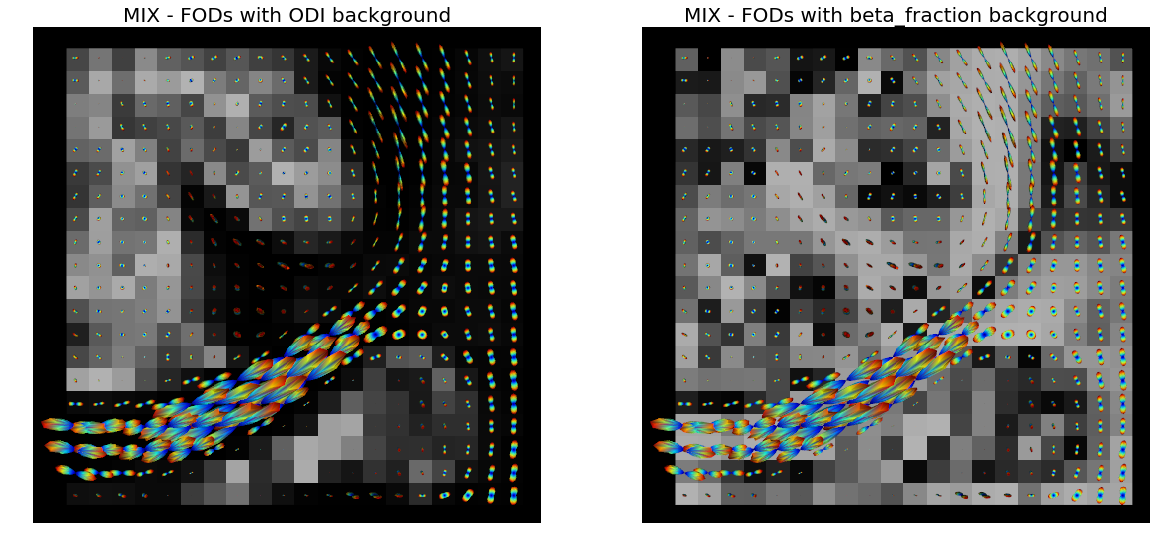

In [89]:
import matplotlib.image as mpimg
img1 = mpimg.imread('dipy_odi.png')
img2 = mpimg.imread('dipy_beta.png')

fig, axs = plt.subplots(1, 2, figsize=[20, 70])
axs[0].set_title('MIX - FODs with ODI background', fontsize=20)
axs[0].imshow(img1[100:-97, 100:-85])
axs[0].axis('off')
axs[1].set_title('MIX - FODs with beta_fraction background', fontsize=20)
axs[1].imshow(img2[100:-97, 100:-85])
axs[1].axis('off');

In [42]:
from os import remove
remove('dipy_odi.png')
remove('dipy_beta.png')

Comparing this image and the one above we can see that the ODI image is very similar, but MIX seems to do a better job at obtaining a smoother beta_fraction map. This is likely due to that Brute2Fine currently insufficiently samples the psi parameter of the Bingham distribution in the Brute step, meaning it will sometimes fall in a local minimum, while MIX uses stochastic sampling over the entire parameter space.

As mentioned, the downside of MIX is that while accurate, it is very slow. To be able to stick with the faster Brute2Fine, we will show that we can use parameter cascading of dipy's DTI to give a good initial_guess for of the orientation and psi parameters for NODDI-Bingham.

## References
<div class="cite2c-biblio"></div>